# Data preprocessing

Pre-procesamiento del dataset de de 35,821 estructuras CRISPR sin redundancia

---
### Definición de librerías y funciones

In [1]:
import os, cv2, random, re
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
seed = 123          # for reproducibility
np.random.seed(seed)

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#Padding and Truncating
from keras.preprocessing import sequence

#One hot encoding
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

#Model
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.layers.merge import concatenate
from keras.regularizers import l1_l2,l2,l1
from keras.callbacks import ModelCheckpoint
from PIL import Image
from keras.utils.vis_utils import plot_model
# Import Joblib Module from Scikit Learn
import joblib

# Definición de funciones
---

DRtoCSVclass(): función para agregar etiqueta a secuencias extraíadas de un arhcivo FASTA y generar un archivo CSV

In [ ]:
def DRtoCSVclass(DRlist):
    i=0
    DRcount = len(DRlist) - 1
    dr = ''
    string = ''
    #La etiqueta es 1 cuando es positivo y 0 para negativo
    label = '1'
    
    ## =========== Variables para manipular archivo de entrada y salida ===========
    ##Rutas pra contabilizar los DirectRepeat de las matrices CRISPR
    outputfile = 'EMPositiveRightDR.csv'

    ## ====================== Se escribe el archivo de salida =====================
    out = open(outputfile, "w")
    description = 'RightDirectRepeat,Label\n'
    out.write(description)
    out.close()
    
    
    for i in range(DRcount):
        #aux = aux + 1
        dr = DRlist[i]
        
        #Linea a escribirse en el archivo CSV
        string = dr+','+label+'\n'
        
        #Se escribe la linea de información al nuevo archivo de salida
        out = open(outputfile, 'a')
        out.write(string)
        out.close()
        
        #Se vacían las variables auxiliares
        dr = ''
        string = ''
    
    
    ##Ultima línea
    
    dr = DRlist[len(DRlist)-1]
    #Linea a escribirse en el archivo CSV
    string = dr+','+label+'\n'
    
    #Se escribe la linea de información al nuevo archivo de salida
    out = open(outputfile, 'a')
    out.write(string)
    out.close()
    
    dr = ''
    string = ''
    
    print('[INFO] Generación del archivo CSV para secuencias DR de extremo 3 prima con etiqueta finalizada...')

TestToList(): función para leer un archivo FASTA y extraer las secuencias en una sola lista de python

In [2]:
def TextToList(fileName):
        dna_list=[]
        with open(fileName) as file:
       
            for line in file:
                li=line.strip()
                if not li.startswith(">"):
                    dna_list.append(line.rstrip("\n"))
        file.close()
        return dna_list

StringLength(): función para analizar las longitudes de las secuencias de una lista.

In [3]:
### StringLength(): función para analizar las longitudes de las secuencias de una lista.
def StringLength(vectorlen, vectorseq):
    listaux = []
    
    for i in vectorseq:
        #print(i)
        length = len(i)
        listaux.append(length)
        
    vectorlen = np.array(listaux)
        
    return vectorlen

DNAnumeric(): función para realizar encoding de las secuencias de nucleótdios con la nomenclatura IUPAC

In [4]:
### DNAnumeric(): función para realizar encoding de las secuencias de nucleótdios con la nomenclatura IUPAC
def DNAnumeric(seq):
    #convierte la secuencia DNA en numerica
    Lette_dict = {'A': 1, 'C': 2, 'G': 3,'T': 4, 'U':0,'R':0,'K':0,'Y':0,'M':0,'S':0,'W':0,'B':0,'D':0,'H':0,'V':0,'N':0}
    seq_list = list(seq)
    seq_list = [Lette_dict[base] for base in seq_list]
   
    return seq_list

ListSeqEncoding(): función que recibe la lista de secuencias del dataset para codificarlas a datos numéricos

In [5]:
### ListSeqEncoding(): función que recibe la lista de secuencias del dataset para codificarlas a datos numéricos
def ListSeqEncoding(listaseq):
    listencoding = []
    arrayencoding = np.array([])
    
    for i in listaseq:
        aux = DNAnumeric(i)
        listencoding.append(aux)
        
    arrayencoding = np.array(listencoding)
    
    
    return arrayencoding

CSQueryEncoding(): función para codificar las secuencias a clasificar por el modelo propuesto.

In [6]:
def CSQueryEncoding(repeat):
  channels = 1
  data_rows = 36
  data_cols = 6
  #Archivo FASTA a lista
  #repeat = TextToList(repeat)
  #Lista con secuencias a vector
  repeatvect = np.array(repeat)

  ## List sequences processing
  repeat = ListSeqProcessing(repeatvect)

  ## Reshape to inputs model
  InputQuery = repeat.reshape(repeat.shape[0], channels, data_rows, data_cols)
  InputQuery = InputQuery.astype('float32')

  return InputQuery

In [7]:
def CSQueryEncodingRight(repeat):
  channels = 1
  data_rows = 36
  data_cols = 6
  #Archivo FASTA a lista
  #repeat = TextToList(repeat)
  #Lista con secuencias a vector
  repeatvect = np.array(repeat)

  ## List sequences processing
  repeat = ListSeqProcessingRight(repeatvect)

  ## Reshape to inputs model
  InputQuery = repeat.reshape(repeat.shape[0], channels, data_rows, data_cols)
  InputQuery = InputQuery.astype('float32')

  return InputQuery

SplitLeftRight(): función que recibe estructuras CRISPR y extrae los DR de los extremos 5' y 3'

In [8]:
#Extracción de repetidores en el extremo 5' y del extremo 3'
def SplitLeftRight(listCS, lendr):
  rightdr = []
  leftdr = []

  for i in listCS:
    #extracción del DR en extremo izquierdo
    #print(i)
    leftdr.append(i[:lendr])
    rightdr.append(i[-lendr:])

  
  leftdr = np.array(leftdr)
  rightdr = np.array(rightdr)

  print('[INFO] Extracción de los DR en los extremos en las CRISPRstructs finalizado...')

  return leftdr, rightdr

In [9]:
#Extracción de repetidores en el extremo 5', espaciador y del extremo 3'
def SplitLeftRightQuery(listCS, CSlen, lendr):
  rightdr = []
  spacers = []
  leftdr = []

  #cálculo de longitud del spacer para extraer
  splen = CSlen - (DRlen * 2)
  spend = DRlen + splen

  for i in listCS:
    #extracción del DR en extremo izquierdo
    #print(i)
    leftdr.append(i[:lendr])
    spacers.append(i[DRlen:spend])
    rightdr.append(i[-lendr:])

  
  leftdr = np.array(leftdr)
  spacers = np.array(spacers)
  rightdr = np.array(rightdr)

  print('[INFO] Extracción de los DR en los extremos en las CRISPRstructs finalizado...')

  return leftdr, spacers, rightdr

CSVofRepeats(): función para generar archivo CSV de la lista de los DR en el extremo 5' y 3' extraídos de las estructuras CRISPR.

In [10]:
## Función para generar CSV de los repetidores en el extremo 5' y también 3'
#de estructuras CRISPR representantes
def CSVofRepeats(listdr):
  count = 1
  description = 'IDCrisprStruct,DirectRepeat\n'
  string = ''


  ##Rutas para almacenar los DR sólo de un extremo
  outputfile = 'CrisprStruct_rightdr.csv'
  #outputfile = 'CrisprStruct_rightdr.csv'
  out = open(outputfile, "w")
  out.write(description)
  out.close()

  for i in listdr:
    string = 'RightDR_'+str(count)+','+i+'\n'
    count = count + 1
    #Se escribe la linea de información al nuevo archivo de salida
    out = open(outputfile, 'a')
    out.write(string)
    out.close()
    string = ''

  print('[INFO] Generación del archivo CSV para DR de CS finalizada...')

ListSeqProcessing(): función que recibe todo el dataset de secuencias de nucleótidos y realizar los siguientes procedimientos:


*   Encoding de las secuencias
*   Padding y truncate de las secunecias
*   One hot encoding para las secuencias

Este paso se realiza previo al split del dataset

In [12]:
def ListSeqProcessing(listsequences):
  X_data = np.array([])
  ### Encoding de las secuencias a datos numéricos
  X_data = ListSeqEncoding(listsequences)
  print('\n[INFO] Transformación de secuencias a datos numéricos finalizada (0-6)...')
  #X_data[0:5]

  ### Padding and truncating for length inputs sequences
  X_data = sequence.pad_sequences(X_data, value=0, maxlen=36, padding="post",truncating='pre')
  print('\n[INFO] Padding (post) and truncate (pre) for length inputs sequences finished...')
  #X_data[0:5,:]

  X_data = np_utils.to_categorical(X_data, num_classes=6)
  print('[INFO] Transformación de vector de secuencias a one-hot encoding (Lx6) finalizada...\n')
  print('[INFO] Dimensión de la matriz one-hot enconding para secuencias: ', X_data.shape)

  return X_data

In [11]:
def ListSeqProcessingRight(listsequences):
  X_data = np.array([])
  ### Encoding de las secuencias a datos numéricos
  X_data = ListSeqEncoding(listsequences)
  print('\n[INFO] Transformación de secuencias a datos numéricos (0-6) finalizada...')
  #X_data[0:5]

  ### Padding and truncating for length inputs sequences right
  X_data = sequence.pad_sequences(X_data, value=0, maxlen=36, padding="pre",truncating='pre')
  print('\n[INFO] Padding (pre) and truncate (pre) for length inputs sequences finished...')
  #X_data[0:5,:]

  X_data = np_utils.to_categorical(X_data, num_classes=6)
  print('[INFO] Transformación de vector de secuencias a one-hot encoding (Lx6) finalizada...\n')
  print('[INFO] Dimensión de la matriz one-hot enconding para secuencias: ', X_data.shape)

  return X_data

OutSpacersFASTA() función para recuperar los spacers de las estructuras CRISPR clasificadas correctamente y escribir un archivo FASTA de salida donde el usuario tendrá los spacers para alinear y detectar al fago huésped.

In [40]:
## OutSpacersFASTA() función para recuperar los spacers de las estructuras CRISPR clasificadas correctamente
def OutSpacersFASTA(UserPredictions, InSpacers):
  predictspacer = ''
  outputfile = 'PredictedSpacers-EMCRISPRstruct.fasta'
  out = open(outputfile, "w")
  out.close()

  count = 0 #Iterador de lista con los spacers predichos

  for i in UserPredictions:
    if i > 0.45:
      #print (i)
      #print (">Predicted spacer from CRISPR struct "+str(count+1)+"\n"+InSpacers[count])
      predictspacer = ">Predicted spacer from CRISPR struct "+str(count+1)+"\n"+InSpacers[count]+"\n"
      #Se escribe la linea de información al nuevo archivo de salida
      out = open(outputfile, 'a')
      out.write(predictspacer)
      out.close()
    
    count = count + 1

  print(outputfile)
  print("[INFO] Archivo de salida (FASTA) con spacer predichos finalizado...")

InputUserData(): función principal para realizar todo el proceso de predicción de fragmentos de estructuras CRISPR de 111 nt desde un archivo FASTA del usuario final al aplicar el modelo entrenado

In [39]:
## InputUserData(): función principal para realizar todo el proceso de predicción de fragmentos
# de estructuras CRISPR de 111 nt desde un archivo FASTA del usuario final al aplicar el modelo entrenado
def InputUserData(fastaInput):
  #Extracción de las secuencias desde el archivo FASTA recibido del usuario
  Input_listaCS = TextToList(fastaInput)
  print('[INFO] Cantidad de estructuras CRISPR: ', len(Input_listaCS))

  #Extracción del DR en el extremo 5', spacer y en el extremo 3' en listas separadas
  InLeftDR, InSpacers, InRightDR = SplitLeftRightQuery(Input_listaCS, CSlen, DRlen)

  #Codificación one-hot de los DR de ambos extremos previo a ser evaluados por el modelo
  Input_leftDR = CSQueryEncoding(InLeftDR)
  print("[INFO] Codificación de los DR en el extremo izquierda finalizada...\n\n")
  Input_rightDR = CSQueryEncodingRight(InRightDR)
  print("[INFO] Codificación de los DR en el extremo derecho finalizada...\n\n")

  print("[INFO] Inicializando predicciones de las estructuras de entrada...\n\n")
  Inputpredict = EMCRISPRstructV2.predict([Input_leftDR, Input_rightDR])

  print('Visualización de las predicciones de las estructuras CRISPR de entrada:\n')
  sns.scatterplot(data=Inputpredict, legend=False)
  plt.title('Predicciones para estructuras CRISPR')
  # Set x-axis label 
  plt.xlabel('Estructuras CRISPR analizadas')
  # Set y-axis label
  plt.ylabel('Probabilidad de clasificación binaria')

  OutSpacersFASTA(Inputpredict, InSpacers)

# Pre-processing dataset
---

## Pre procesamiento de estructuras CRISPR

Se importan el archivo FASTA que contiene las 35,821 estructuras CRISPR sin redundancia, es decir, cada estructura CRISPR es única.


In [ ]:
#Load local CRISPRstruct dataset
## Reading the data
from google.colab import files
uploaded = files.upload()

Saving CrisprStrcutIDtaxCdhit100.fasta to CrisprStrcutIDtaxCdhit100.fasta


Extracción de estructuras CRISPR sin redundancia y almacenarlas en una lista de python

In [ ]:
#Extracción de estructuras CRISPR a una lista
fastaCS = 'CrisprStrcutIDtaxCdhit100.fasta'
listCS = TextToList(fastaCS)
listCS = np.array(listCS)
listCS[:5]

array(['GTCTAAGTCCCTTTAAATGGCGGGGCGTCTTTCAGAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG',
       'GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG',
       'GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG',
       'GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG',
       'ACATTAACCCCCTAAAATCGCGGGGAGTCTTTCAGAGNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG'],
      dtype='<U206')

Extracción de los DR en los extremos 5' y 3' de las 35,821 estructuras CRISPR

In [ ]:
#Extraccción de repetidores en los extremos 5' y 3' de una longitud de 36 nucleótidos
#correspondiente al tercer cuartil en estadísticas de longitudes de DR
lendr = 36
leftdr = np.array([])
rightdr = np.array([])
leftdr, rightdr = SplitLeftRight(listCS, lendr)
print("Total de DR en extremo 5':\n", len(leftdr))
print("Total de DR en extremo 3':\n", len(rightdr))
print('Vector de DR de extremo izquierdo (5 prima):\n')
print(leftdr[:5])
print('\nVector de DR de extremo derecho (3 prima):\n')
print(rightdr[:5])

Total de DR en extremo 5':
 35821
Total de DR en extremo 3':
 35821
Vector de DR de extremo izquierdo (5 prima):

['GTCTAAGTCCCTTTAAATGGCGGGGCGTCTTTCAGA'
 'GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA'
 'GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA'
 'GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA'
 'ACATTAACCCCCTAAAATCGCGGGGAGTCTTTCAGA']

Vector de DR de extremo derecho (3 prima):

['TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG'
 'TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG'
 'TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG'
 'TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG'
 'TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG']


#### Generación de archvio CSV para los 35,821 DR del extremo 5' con su etiqueta positiva (1)

In [ ]:
#Generación de archvio CSV para los 35,821 DR del extremo 5' con su etiqueta positiva (1)
DRtoCSVclass(leftdr)

[INFO] Generación del archivo CSV para secuencias DR de extremo 5 prima con etiqueta finalizada...


Generación de archvio CSV para los 35,821 DR del extremo 3' con su etiqueta positiva (1)

In [ ]:
#Generación de archvio CSV para los 35,821 DR del extremo 3' con su etiqueta positiva (1)
DRtoCSVclass(rightdr)

[INFO] Generación del archivo CSV para secuencias DR de extremo 3 prima con etiqueta finalizada...


## Procesamiento del conjunto de datos

Importando el conjunto de datos de DR en el extremo 5', DR del extremo 3' y el conjunto de datos negativo de CRF con 12mil secuencias y su etiqueta negativa

In [13]:
# loading positive left dr dataset from csv - github
positiveleftdata = "https://github.com/Edna-Cruz-Fl/EMCRISPRstruct/raw/main/Dataset/EMPositiveLeftDR.csv"
# loading positive right dr dataset from csv - github
positiverightdata = "https://github.com/Edna-Cruz-Fl/EMCRISPRstruct/raw/main/Dataset/EMPositiveRightDR.csv"
# loading negative dataset from csv - github
negativedata = "https://github.com/Edna-Cruz-Fl/EMCRISPRstruct/raw/main/Dataset/NegativeDR.csv"

In [14]:
### Data preprocessing
# loading positive left dr dataset from csv
positiveleftdata = pd.read_csv(positiveleftdata)
print('Dataset con secuencias DR izquierdas positivas')
print(positiveleftdata.head(),'\n')

# loading positive right dr dataset from csv
positiverightdata = pd.read_csv(positiverightdata)
print('Dataset con secuencias DR derechas positivas')
print(positiverightdata.head(),'\n')

# loading negative dataset from csv
negativedata = pd.read_csv(negativedata)
print('Dataset con secuencias DR negativas')
print(negativedata.head(),'\n')

Dataset con secuencias DR izquierdas positivas
                       LeftDirectRepeat  Label
0  GTCTAAGTCCCTTTAAATGGCGGGGCGTCTTTCAGA      1
1  GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA      1
2  GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA      1
3  GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA      1
4  ACATTAACCCCCTAAAATCGCGGGGAGTCTTTCAGA      1 

Dataset con secuencias DR derechas positivas
                      RightDirectRepeat  Label
0  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1
1  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1
2  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1
3  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1
4  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1 

Dataset con secuencias DR negativas
                   DirectRepeat  Label
0  ACACTGACTGAGAAGGGGTCCCCCTTTG      0
1  AACCGTACCGAAGGGGGTTGCTTGACAC      0
2  CAGCAAACGCACTTAGCAGTGGGTCAAA      0
3  GGGGGAGGATGTGAGTCGGCGAGACCTC      0
4  AACGCGACCATTACCTGAATCAAGAATC      0 



### Construcción de dataset de DR en el extremo 5'

El Dataset para el modelo del extremo 5' (izquierdo) y del extremo 3' (derecho) se conforma por 35,821 secuecias DR positivas y el dataset negativo con 12,011 secuencias DR, finalmente se obtuvo un total de 47,832 secuencias en el dataset

In [15]:
##Cambiar nombre de la columna dl DF con dataset negativo para concatenar
negativedata.rename(columns={'DirectRepeat': 'LeftDirectRepeat'}, inplace=True)
negativedata.columns

Index(['LeftDirectRepeat', 'Label'], dtype='object')

Uniendo el dataset positivo de DR en el extremo 5' con el dataset negativo de CRF

In [16]:
# Apilar los __DataFrames__ uno encima del otro
leftdataset = pd.concat([positiveleftdata, negativedata], axis=0)
# Suffle del dataset con clase positiva y negativa
#leftdataset = shuffle(leftdataset)
#print('Dataset izquierdo con las secuencias positivas y negativas')
print(leftdataset.head(),'\n')
print(leftdataset.tail(),'\n')

                       LeftDirectRepeat  Label
0  GTCTAAGTCCCTTTAAATGGCGGGGCGTCTTTCAGA      1
1  GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA      1
2  GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA      1
3  GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA      1
4  ACATTAACCCCCTAAAATCGCGGGGAGTCTTTCAGA      1 

                                        LeftDirectRepeat  Label
12006  CGTCATAAAAGGGGGTCGCGAGTATAGGCCTGAGGAGTACCTATAT...      0
12007  CCGGTCAATTTGGGGTTTCCCGCTCCTCGACGAGTGAGTGATGCGT...      0
12008  TTATAGAGCCTTCGACGCAAATTCTGCTAACCAGAGCTAGGTTCAT...      0
12009  AGTATGGCACCGGATTGACTGTGATGATTTAACGAAGTACAGCCCT...      0
12010  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...      0 



### Construcción de dataset de DR en el extremo 3'

In [17]:
##Cambiar nombre de la columna dl DF con dataset negativo para concatenar con
# dataste positivo
negativedata.rename(columns={'LeftDirectRepeat': 'RightDirectRepeat'}, inplace=True)
negativedata.columns

Index(['RightDirectRepeat', 'Label'], dtype='object')

In [18]:
### Data preparation
# Apilar los __DataFrames__ uno encima del otro
rightdataset = pd.concat([positiverightdata, negativedata], axis=0)
# Suffle del dataset con clase positiva y negativa
#rightdataset = shuffle(rightdataset)
#print('Dataset izquierdo con las secuencias positivas y negativas')
print(rightdataset.head(),'\n')
print(rightdataset.tail(),'\n')

                      RightDirectRepeat  Label
0  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1
1  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1
2  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1
3  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1
4  TCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGAG      1 

                                       RightDirectRepeat  Label
12006  CGTCATAAAAGGGGGTCGCGAGTATAGGCCTGAGGAGTACCTATAT...      0
12007  CCGGTCAATTTGGGGTTTCCCGCTCCTCGACGAGTGAGTGATGCGT...      0
12008  TTATAGAGCCTTCGACGCAAATTCTGCTAACCAGAGCTAGGTTCAT...      0
12009  AGTATGGCACCGGATTGACTGTGATGATTTAACGAAGTACAGCCCT...      0
12010  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...      0 



## Transformación de los conjuntos de datos para el extremo 5' y 3' en matrices

In [19]:
### Data preparation left model 
# Dataframe to numpy matrix from left DR
leftdataset = leftdataset.to_numpy()
# Columna de secuencias: leftdataset[:,0] y columna de labels: leftdataset[:,1]
print('[INFO] Left Dataset en una sola matriz:\n',leftdataset[0:5,:])


# Dataframe to numpy matrix from right DR
rightdataset = rightdataset.to_numpy()
print('\n[INFO] Right Dataset en una sola matriz:\n',leftdataset[0:5,:])

[INFO] Left Dataset en una sola matriz:
 [['GTCTAAGTCCCTTTAAATGGCGGGGCGTCTTTCAGA' 1]
 ['GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA' 1]
 ['GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA' 1]
 ['GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA' 1]
 ['ACATTAACCCCCTAAAATCGCGGGGAGTCTTTCAGA' 1]]

[INFO] Right Dataset en una sola matriz:
 [['GTCTAAGTCCCTTTAAATGGCGGGGCGTCTTTCAGA' 1]
 ['GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA' 1]
 ['GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA' 1]
 ['GTCTTAATCCCCTTAAATGGCGGGGCGTCTTTCAGA' 1]
 ['ACATTAACCCCCTAAAATCGCGGGGAGTCTTTCAGA' 1]]


In [69]:
# Extracción de las secuencias y etiquetas por separado
x_leftdata = leftdataset[:,0]
y_leftlabels = leftdataset[:,1]
#leftsamples = len(leftdataset[:,1])
print('\n[INFO] Dimensión de vector de DR izquiedos: ',x_leftdata.shape)
print('\n[INFO] Dimensión de la matriz DR izquierdos: ',y_leftlabels.shape)


[INFO] Dimensión de vector de DR izquiedos:  (47832,)

[INFO] Dimensión de la matriz DR izquierdos:  (47832,)


In [70]:
# Extracción de las secuencias y etiquetas por separado
x_rightdata = rightdataset[:,0]
y_rightlabels = rightdataset[:,1]
#leftsamples = len(leftdataset[:,1])
print('\n[INFO] Dimensión de vector de DR derechos: ',x_rightdata.shape)
print('\n[INFO] Dimensión de la matriz DR derechos: ',y_rightlabels.shape)


[INFO] Dimensión de vector de DR derechos:  (47832,)

[INFO] Dimensión de la matriz DR derechos:  (47832,)


### Encoding de las secuencias de nucleótidos para el extremo 5'

List sequences processing

Procesamiento de x_leftdata que contiene secuencias de nucleótidos contenidas en una lista.

*   Encoding de las secuencias
*   Padding y truncate de las secunecias
*   One hot encoding para las secuencias

In [71]:
X_Leftdata = ListSeqProcessing(x_leftdata)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.



[INFO] Transformación de secuencias a datos numéricos finalizada (0-6)...

[INFO] Padding (post) and truncate (pre) for length inputs sequences finished...
[INFO] Transformación de vector de secuencias a one-hot encoding (Lx6) finalizada...

[INFO] Dimensión de la matriz one-hot enconding para secuencias:  (47832, 36, 6)


### Encoding de las secuencias de nucleótidos para el extremo 3'

List sequences processing

Procesamiento de x_rightdata que contiene secuencias de nucleótidos contenidas en una lista.

*   Encoding de las secuencias
*   Padding y truncate de las secunecias
*   One hot encoding para las secuencias

In [72]:
X_Rightdata = ListSeqProcessingRight(x_rightdata)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.



[INFO] Transformación de secuencias a datos numéricos (0-6) finalizada...

[INFO] Padding (pre) and truncate (pre) for length inputs sequences finished...
[INFO] Transformación de vector de secuencias a one-hot encoding (Lx6) finalizada...

[INFO] Dimensión de la matriz one-hot enconding para secuencias:  (47832, 36, 6)


## Partición del los conjunto de datos para el extremo 5' y 3' en prueba y entrenamiento

In [73]:
### train_test_split function: split the data into train and test sets
X_trainLeft, X_testLeft, y_trainLeft, y_testLeft, X_trainRight, X_testRight, y_trainRight, y_testRight = train_test_split(X_Leftdata, y_leftlabels,
                                                                                                                          X_Rightdata, y_rightlabels,
                                                                                                                          test_size=0.2,
                                                                                                                          random_state=42,
                                                                                                                          stratify=y_rightlabels)

#Imprmir el conjunto de datos tras la fragmentación del dataset extremo 5
print('[INFO] Dimension de matriz X_trainLeft extremo 5: ',X_trainLeft.shape)
print('[INFO] Dimension de matriz y_trainLeft extremo 5: ',y_trainLeft.shape)
print('[INFO] Dimension de matriz X_testLeft extremo 5: ',X_testLeft.shape)
print('[INFO] Dimension de matriz y_testLeft extremo 5: ',y_testLeft.shape)

#Imprmir el conjunto de datos tras la fragmentación del dataset extremo 3
print('\n[INFO] Dimension de matriz X_trainRight extremo 3: ',X_trainLeft.shape)
print('[INFO] Dimension de matriz y_trainRight extremo 3: ',y_trainLeft.shape)
print('[INFO] Dimension de matriz X_testRight extremo 3: ',X_testLeft.shape)
print('[INFO] Dimension de matriz y_testRight extremo 3: ',y_testLeft.shape)

[INFO] Dimension de matriz X_trainLeft extremo 5:  (38265, 36, 6)
[INFO] Dimension de matriz y_trainLeft extremo 5:  (38265,)
[INFO] Dimension de matriz X_testLeft extremo 5:  (9567, 36, 6)
[INFO] Dimension de matriz y_testLeft extremo 5:  (9567,)

[INFO] Dimension de matriz X_trainRight extremo 3:  (38265, 36, 6)
[INFO] Dimension de matriz y_trainRight extremo 3:  (38265,)
[INFO] Dimension de matriz X_testRight extremo 3:  (9567, 36, 6)
[INFO] Dimension de matriz y_testRight extremo 3:  (9567,)


In [ ]:
#Comparación de etiquetas entre el split del dataset para el extremo 5' contra
#el extremo 3'
#Vector de etiquetas en el conjunto de prueba para el extremo 5'
print(y_testLeft)
#Vector de etiquetas en el conjunto de prueba para el extremo 3'
print(y_testRight)

[0 1 1 ... 0 1 1]
[0 1 1 ... 0 1 1]


## Preparación de los datos de entrada para el modelo ensamblado

In [74]:
### Network parameters
batches = 32
epochs = 60

data_rows = X_trainLeft.shape[1]
data_cols = X_trainLeft.shape[2]
channels = 1
dim_input = (channels,data_rows,data_cols)

Procesamiento de los datos de entrada para el modelo del extremo 5'

In [75]:
### Preprocess the inputs left model
X_trainLeft = X_trainLeft.reshape(X_trainLeft.shape[0], channels, data_rows, data_cols)
X_trainLeft = X_trainLeft.astype('float32')
X_testLeft = X_testLeft.reshape(X_testLeft.shape[0], channels, data_rows, data_cols)
X_testLeft = X_testLeft.astype('float32')

# Preprocess the labels left model
y_testLeft = y_testLeft.astype('float32')
y_trainLeft = y_trainLeft.astype('float32')

In [ ]:
print('Shape of training left DR: ')
print(X_trainLeft.shape)
print(y_trainLeft.shape)
print('Shape of test data left DR: ')
print(X_testLeft.shape)
print(y_testLeft.shape)

Shape of training left DR: 
(38265, 1, 36, 6)
(38265,)
Shape of test data left DR: 
(9567, 1, 36, 6)
(9567,)


Procesamiento de los datos de entrada para el modelo del extremo 3'

In [76]:
### Preprocess the inputs right DR
X_trainRight = X_trainRight.reshape(X_trainRight.shape[0], channels, data_rows, data_cols)
X_trainRight = X_trainRight.astype('float32')
X_testRight = X_testRight.reshape(X_testRight.shape[0], channels, data_rows, data_cols)
X_testRight = X_testRight.astype('float32')

# Preprocess the labels right DR
y_testRight = y_testRight.astype('float32')
y_trainRight = y_trainRight.astype('float32')

In [ ]:
print('Shape of training right DR: ')
print(X_trainRight.shape)
print(y_trainRight.shape)
print('Shape of test data right DR: ')
print(X_testRight.shape)
print(y_testRight.shape)

Shape of training right DR: 
(38265, 1, 36, 6)
(38265,)
Shape of test data right DR: 
(9567, 1, 36, 6)
(9567,)


# Initialising the ensemble model for CRISPR structus

In [77]:
# Initialising the left CNN model
leftDR = Sequential()
# Step 1 - Convolution
leftDR.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                    input_shape= dim_input, data_format='channels_first'))
# Step 2 - Pooling
leftDR.add(MaxPooling2D(pool_size = (2, 2)))
leftDR.add(Dropout(0.10))
# Adding a second convolutional layer
leftDR.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
leftDR.add(MaxPooling2D(pool_size = (2, 2)))
leftDR.add(Dropout(0.25))
# Adding a third convolutional layer
leftDR.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
leftDR.add(MaxPooling2D(pool_size = (2, 2)))
leftDR.add(Dropout(0.25))
# Adding a fourth convolutional layer
#model.add(Conv2D(128, (3, 3), activation = 'relu'))
#model.add(MaxPooling2D(pool_size = (2, 2)))
#model.add(Dropout(0.25))
# Step 3 - Flattening
leftDR.add(Flatten())


# Initialising the right CNN model
rightDR = Sequential()
# Step 1 - Convolution
rightDR.add(Conv2D(32, (3, 3), padding='same', activation='relu',
                     input_shape = dim_input , data_format='channels_first'))
# Step 2 - Pooling
rightDR.add(MaxPooling2D(pool_size = (2, 2)))
rightDR.add(Dropout(0.10))
# Adding a second convolutional layer
rightDR.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
rightDR.add(MaxPooling2D(pool_size = (2, 2)))
rightDR.add(Dropout(0.25))
# Adding a third convolutional layer
rightDR.add(Conv2D(128, (3, 3), padding='same', activation = 'relu'))
rightDR.add(MaxPooling2D(pool_size = (2, 2)))
rightDR.add(Dropout(0.25))
# Adding a fourth convolutional layer
#model.add(Conv2D(128, (3, 3), activation = 'relu'))
#model.add(MaxPooling2D(pool_size = (2, 2)))
#model.add(Dropout(0.25))
# Step 3 - Flattening
rightDR.add(Flatten())

# Step 4 - Full connection ensemble model
# merge input models
DRflankscombined = concatenate([leftDR.output, rightDR.output])

InputNNlayer = Dense(units = 64, activation = 'relu',  kernel_regularizer=l1(9e-5))(DRflankscombined)
OutputNNlayer = Dense(units = 1, activation='sigmoid')(InputNNlayer)
EMCRISPRstructV2 = Model(inputs=[leftDR.input, rightDR.input], outputs= OutputNNlayer)

print(EMCRISPRstructV2.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_12_input (InputLayer)    [(None, 1, 36, 6)]   0                                            
__________________________________________________________________________________________________
conv2d_15_input (InputLayer)    [(None, 1, 36, 6)]   0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 36, 6)    320         conv2d_12_input[0][0]            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 32, 36, 6)    320         conv2d_15_input[0][0]            
____________________________________________________________________________________________

## Compiling the CNN from left model

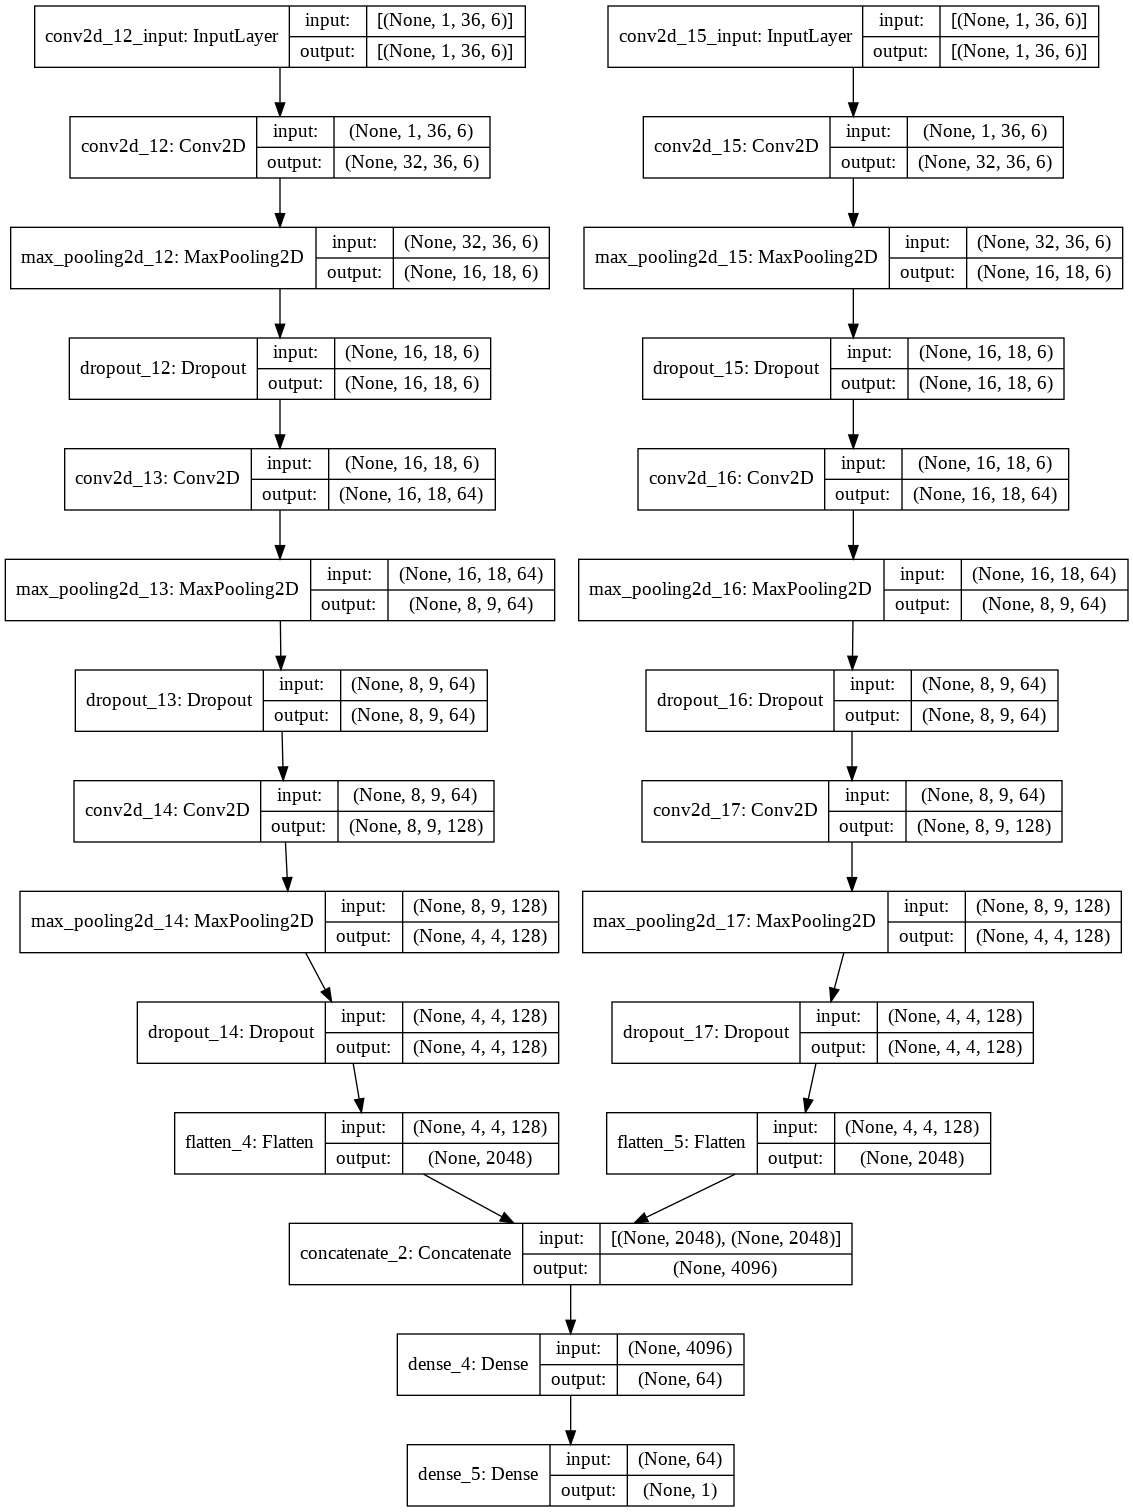

In [78]:
# Compiling the CNN
EMCRISPRstructV2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


model = "best2_EMCRISPRstructV2.hdf5"
checkpoint = ModelCheckpoint(model, monitor='val_accuracy', verbose=0,
                             save_weights_only=False,
                             save_best_only=True, mode='max')


plot_model(EMCRISPRstructV2, to_file='cnn_EMCRISPRstructV2.png', show_shapes=True, show_layer_names=True)
display(Image.open('cnn_EMCRISPRstructV2.png'))

## Fit ensembled model

In [79]:
#Entrenamiento del modelo con los datos del test y se realiza la validación 
EMCRISPRstruct_history = EMCRISPRstructV2.fit(x= [X_trainLeft, X_trainRight], y= y_trainLeft, 
                                            epochs= epochs,
                                            batch_size= batches,
                                            callbacks=[checkpoint],
                                            validation_data=([X_testLeft, X_testRight], y_testLeft))

Epoch 1/60
1196/1196 [==============================] - 7s 5ms/step - loss: 0.3276 - accuracy: 0.9087 - val_loss: 0.1108 - val_accuracy: 0.9723
Epoch 2/60
1196/1196 [==============================] - 6s 5ms/step - loss: 0.1054 - accuracy: 0.9715 - val_loss: 0.0835 - val_accuracy: 0.9802
Epoch 3/60
1196/1196 [==============================] - 6s 5ms/step - loss: 0.0800 - accuracy: 0.9791 - val_loss: 0.0724 - val_accuracy: 0.9833
Epoch 4/60
1196/1196 [==============================] - 6s 5ms/step - loss: 0.0700 - accuracy: 0.9828 - val_loss: 0.0624 - val_accuracy: 0.9862
Epoch 5/60
1196/1196 [==============================] - 6s 5ms/step - loss: 0.0607 - accuracy: 0.9853 - val_loss: 0.0579 - val_accuracy: 0.9866
Epoch 6/60
1196/1196 [==============================] - 6s 5ms/step - loss: 0.0533 - accuracy: 0.9873 - val_loss: 0.0519 - val_accuracy: 0.9879
Epoch 7/60
1196/1196 [==============================] - 6s 5ms/step - loss: 0.0480 - accuracy: 0.9884 - val_loss: 0.0502 - val_accuracy:

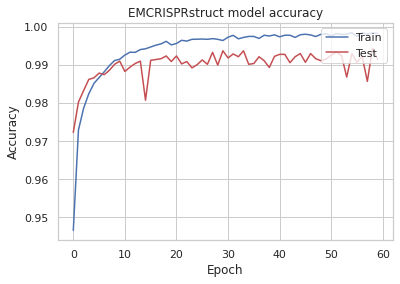

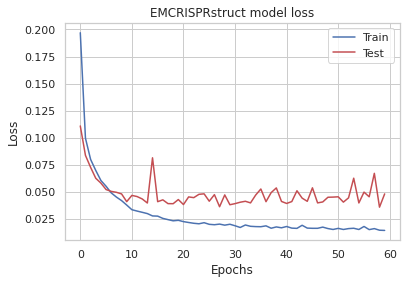

In [80]:
# Plot training & validation accuracy values
plt.plot(EMCRISPRstruct_history.history['accuracy'],'b')
plt.plot(EMCRISPRstruct_history.history['val_accuracy'],'r')
plt.title('EMCRISPRstruct model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.plot(EMCRISPRstruct_history.history['loss'],'b')
plt.plot(EMCRISPRstruct_history.history['val_loss'],'r')
plt.title('EMCRISPRstruct model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [81]:
# Getting score metrics from our model
EMCRISPRstruct_scores = EMCRISPRstructV2.evaluate([X_testLeft, X_testRight], [y_testLeft, y_testRight], verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (EMCRISPRstruct_scores[1]*100))

Accuracy: 99.14%


In [84]:
print("[INFO] Predicciones del dataset de entrenamiento...")
predicsOnTrain = EMCRISPRstructV2.predict([X_trainLeft[:5], X_trainRight[:5]])
predicsOnTrain

[INFO] Predicciones del dataset de entrenamiento...


array([[1.0000000e+00],
       [9.9999976e-01],
       [9.9999821e-01],
       [4.1672263e-07],
       [9.9999952e-01]], dtype=float32)

Text(0, 0.5, 'Estructuras CRISPR analizadas')

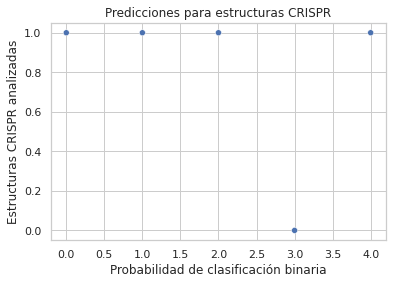

In [85]:
sns.scatterplot(data=predicsOnTrain, legend=False)
plt.title('Predicciones para estructuras CRISPR')
# Set x-axis label
plt.xlabel('Probabilidad de clasificación binaria')
# Set y-axis label
plt.ylabel('Estructuras CRISPR analizadas')

In [35]:
print("[INFO] Verificación de etiquetas predichas en train...")
print("\nEtiquetas reales de DR en extremo 5':\n",y_trainLeft[:5])
print("\nEtiquetas reales de DR en extremo 3':\n",y_trainRight[:5])

[INFO] Verificación de etiquetas predichas en train...

Etiquetas reales de DR en extremo 5':
 [1. 1. 1. 0. 1.]

Etiquetas reales de DR en extremo 3':
 [1. 1. 1. 0. 1.]


In [86]:
print("[INFO] Predicciones del dataset de prueba...")
predicsOnTest = EMCRISPRstructV2.predict([X_testLeft[:5], X_testRight[:5]])
predicsOnTest

[INFO] Predicciones del dataset de prueba...


array([[1.7343267e-05],
       [9.9998832e-01],
       [9.9999964e-01],
       [5.4462372e-12],
       [9.9999619e-01]], dtype=float32)

Text(0, 0.5, 'Probabilidad de clasificación binaria')

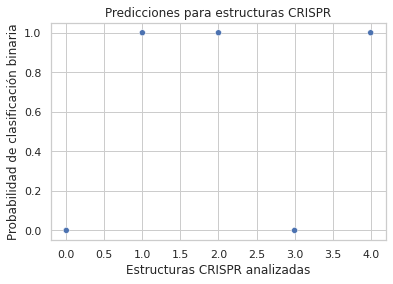

In [87]:
sns.scatterplot(data=predicsOnTest, legend=False)
plt.title('Predicciones para estructuras CRISPR')
# Set x-axis label
plt.xlabel('Estructuras CRISPR analizadas')
# Set y-axis label
plt.ylabel('Probabilidad de clasificación binaria')

In [88]:
print("[INFO] Verificación de etiquetas predichas en test de prueba...")
print("\nEtiquetas reales de DR en extremo 5':\n",y_testLeft[:5])
print("\nEtiquetas reales de DR en extremo 3':\n",y_testRight[:5])

[INFO] Verificación de etiquetas predichas en test de prueba...

Etiquetas reales de DR en extremo 5':
 [0. 1. 1. 0. 1.]

Etiquetas reales de DR en extremo 3':
 [0. 1. 1. 0. 1.]


## Guardando el modelo final Ensemble Model CRISPR Struct (EMCRISPRstruct)

In [102]:
# Save the Modle to file in the current working directory
# serialize to JSON
joblib_EMCRISPRstruct = "EMCRISPRstruct_finalmodelV2-60epochs.hdf5"  
joblib.dump('EMCRISPRstructV2', joblib_EMCRISPRstruct)

['EMCRISPRstruct_finalmodelV2-60epochs.hdf5']

In [103]:
# Import pickle Package
import pickle
# Save the Modle to file in the current working directory
EMCRISPRstruct_pkl= "EMCRISPRstruct_finalmodelV2-60epochs.pkl"  

with open(EMCRISPRstruct_pkl, 'wb') as file:  
    pickle.dump('EMCRISPRstructV2', file)


# Pruebas del modelo ensamblado para estructuras CRISPR (EMCRISPRstruct)
---

###Clasificación de estructuras CRISPR reales con su spacer correspondiente y de una longitud de 111 nucleótidos.

In [42]:
#Load local trined model for testing
## Reading the data
from google.colab import files
uploaded = files.upload()

Saving Input_test-EMcrisprstruct.fasta to Input_test-EMcrisprstruct.fasta


In [49]:
#Load local FASTA file for testing (Reals CRISPR structs)
## Reading the data
from google.colab import files
uploaded = files.upload()

Saving InputtestPositive111nt.fasta to InputtestPositive111nt.fasta


[INFO] Cantidad de estructuras CRISPR:  10
[INFO] Extracción de los DR en los extremos en las CRISPRstructs finalizado...

[INFO] Transformación de secuencias a datos numéricos finalizada (0-6)...

[INFO] Padding (post) and truncate (pre) for length inputs sequences finished...
[INFO] Transformación de vector de secuencias a one-hot encoding (Lx6) finalizada...

[INFO] Dimensión de la matriz one-hot enconding para secuencias:  (10, 36, 6)
[INFO] Codificación de los DR en el extremo izquierda finalizada...



[INFO] Transformación de secuencias a datos numéricos (0-6) finalizada...

[INFO] Padding (pre) and truncate (pre) for length inputs sequences finished...
[INFO] Transformación de vector de secuencias a one-hot encoding (Lx6) finalizada...

[INFO] Dimensión de la matriz one-hot enconding para secuencias:  (10, 36, 6)
[INFO] Codificación de los DR en el extremo derecho finalizada...


[INFO] Inicializando predicciones de las estructuras de entrada...


Visualización de las prediccio

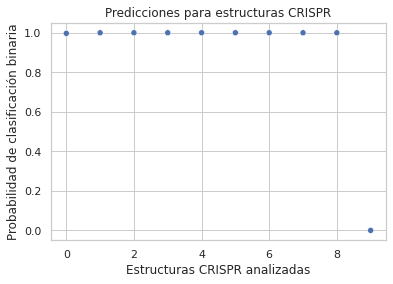

In [100]:
#Parámetros definidos por el usuario final
CSlen = 111  #Longitud de las estructuras CRISPR extraídas de la secuencia bacteriana
DRlen = 36   #Longitud recomendada del repetidor a extraer de las estructuras CRISPR

#Archivo de entrada
fastaInput = "InputtestPositive111nt.fasta"

#Llamada de la función principal para predicciones desde un archivo de entrada
InputUserData(fastaInput)

[INFO] Cantidad de estructuras CRISPR:  10
[INFO] Extracción de los DR en los extremos en las CRISPRstructs finalizado...

[INFO] Transformación de secuencias a datos numéricos finalizada (0-6)...

[INFO] Padding (post) and truncate (pre) for length inputs sequences finished...
[INFO] Transformación de vector de secuencias a one-hot encoding (Lx6) finalizada...

[INFO] Dimensión de la matriz one-hot enconding para secuencias:  (10, 36, 6)
[INFO] Codificación de los DR en el extremo izquierda finalizada...



[INFO] Transformación de secuencias a datos numéricos (0-6) finalizada...

[INFO] Padding (pre) and truncate (pre) for length inputs sequences finished...
[INFO] Transformación de vector de secuencias a one-hot encoding (Lx6) finalizada...

[INFO] Dimensión de la matriz one-hot enconding para secuencias:  (10, 36, 6)
[INFO] Codificación de los DR en el extremo derecho finalizada...


[INFO] Inicializando predicciones de las estructuras de entrada...


Visualización de las prediccio

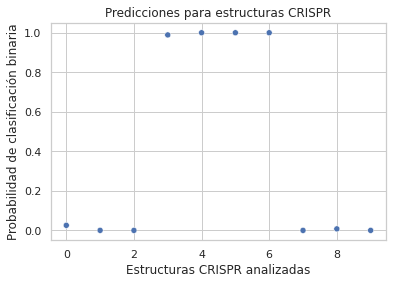

In [101]:
#Parámetros definidos por el usuario final
CSlen = 111  #Longitud de las estructuras CRISPR extraídas de la secuencia bacteriana
DRlen = 36   #Longitud recomendada del repetidor a extraer de las estructuras CRISPR

#Archivo de entrada
fastaInput2 = "Input_test-EMcrisprstruct.fasta"

InputUserData(fastaInput2)

# Fin del pipeline

### Estadísticas de las longitudes de las secuencias en el dataset

[INFO] Total de secuencias en X_data:  31990

Mayor númmero de nucleótidos en una secuencia: 60
Menor número de nucleótidos en una secuencia: 23
Media del núm de nucleótidos de DirectRepeat: 33.25
Mediana:  33.0
Cuartil 25%:  29.0
Cuartil 50%:  33.0
Cuartil 75%:  36.0
Desviación estándar del núm de nucleótidos: 4.46
Moda del núm de nucleótidos de DirectRepeat:
 ModeResult(mode=array([29]), count=array([5872]))


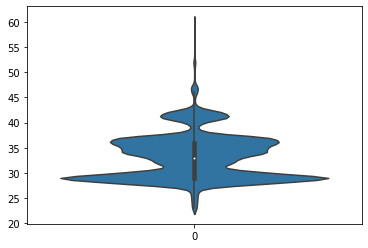

In [ ]:
### Estadísticas (conocer dimensiones de las secuencias en el dataset)
# Array para almacenar las longitudes
vectorlenDR = np.zeros(31990)
# Cálculo de las longitudes de las secuencias
vectorlenDR = StringLength(vectorlenDR, x_data)
# Se eliminan los espacios vacíos con ceros
vectorlenDR = np.trim_zeros(vectorlenDR)

# Cálculo de medidas de tendencia de las longitudes
print('[INFO] Total de secuencias en X_data: ', samples)
print('\nMayor númmero de nucleótidos en una secuencia: {:,.0f}'.format(np.max(vectorlenDR)))
print('Menor número de nucleótidos en una secuencia: {:,.0f}'.format(np.min(vectorlenDR)))
print('Media del núm de nucleótidos de DirectRepeat: {:,.2f}'.format(np.mean(vectorlenDR)))
print('Mediana: ', np.median(vectorlenDR))
print('Cuartil 25%: ', np.percentile(vectorlenDR, 25))
print('Cuartil 50%: ', np.percentile(vectorlenDR, 50))
print('Cuartil 75%: ', np.percentile(vectorlenDR, 75))
print('Desviación estándar del núm de nucleótidos: {:,.2f}'.format(np.std(vectorlenDR)))
print('Moda del núm de nucleótidos de DirectRepeat:\n', stats.mode(vectorlenDR))

sns.violinplot(data=vectorlenDR,inner='box')

Referencias:



*   https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
*   https://github.com/keras-team/keras/issues/13021
*   https://stackoverflow.com/questions/43150635/combining-the-outputs-of-multiple-models-into-one-model

